In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

In [4]:
"""
Feature Tester
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

class FeatureTester():
        
    def __init__(self, data, test_size=0.2, random_seed='random', cv=5, precision=4):
        """
        Initialize the feature tester, provide data as a pandas dataframe, including the y column
        """
        self.data = data
        # features to use, and type of feature
        self.features = []
        # features not to use
        self.dont_use = []
        # list of estimators and their names
        self.estimators = []
        self.names = []
        # random seem to train_test_split
        if (random_seed=='random'):
            self.random_seed = np.random.randint(0,1000)
        # test size (in train_test_split)
        self.test_size = test_size
        # number of CV iterations
        self.cv = cv
        # number of decimal points to show
        self.precision = precision
        # previous scores for comparison
        self.previous = None
        # feature scaler
        self.scaler = StandardScaler()
        
    def set_y(self,column):
        """Mark the y column (by name)"""
        self.y = column
    
    def add_feature(self,feature,dtype='numerical',arg='auto'):
        """
        Add feature to the regression
            default is numerical
            
            ordinal can be specified in dtype, if so, a conversion dictionary might be required
            
            categorical can be specified in dtype, if so, feature will be converted to dummy columns
                by default omitting NaN or the least frequest label
                (otherwise, dummy to omit can be specified by name)
        """
        if (dtype=='numerical'):
            # check that there are no missing values
            if (data[feature].isnull().sum()>0):
                if (arg is None):
                    raise ValueError('This feature has missing values, add missing values manually\
                                     or specify a default value')
                else:
                    # arg is the default value
                    self.features.append((feature,dtype,arg))
            else:
                # add as is
                self.features.append((feature,dtype))
        elif(dtype=='ordinal'):
            # add converted with optional dictionary
            self.features.append((feature,dtype,arg))
        elif(dtype=='categorical'):
            # add converted to dummies
            self.features.append((feature,dtype,arg))  
    
    def print_features(self,type_filter=None,return_tuple=False):
        """Return list of features in a concise representation"""
        if (type_filter) == None:
            return [feature[0] for feature in self.features]
        elif (return_tuple):
            return [feature for feature in self.features if feature[1]==type_filter]
        else:
            return [feature[0] for feature in self.features if feature[1]==type_filter]
    
    def find_feature_index(self,feature):
        """Find the index of a feature by name"""
        i = 0
        for f in self.features:
            if (f[0] == feature):
                break
            i+=1
        return i

    def modify_feature(self,feature,dtype,arg=None):
        """Modify a feature and score it"""
        i = self.find_feature_index(feature)
        if (arg is None):
            if (dtype=='numerical'):
                if (arg is None):
                    if (data[feature].isnull().sum()>0):
                        raise ValueError('This feature has missing values, add missing values manually\
                                     or specify a default value')
                    self.features[i] = (feature,dtype)
                else:
                    self.features[i] = (feature,dtype,arg)
            else:
                self.features[i] = (feature,dtype,'auto')
        else:
            self.features[i] = (feature,dtype,arg)
        return self.score_feature(feature)
    
    def remove_feature(self,feature):
        """Move the last added feature(s) to the No pile
        """
        i = self.find_feature_index(feature)
        removed = self.features.pop(i)
        self.dont_use.append(removed[0])
        # run fit again to correct self.previous
        self.fit()
    
    def add_estimator(self,estimator,name):
        """Add a named estimator to perform regression with"""
        self.estimators.append(estimator)
        self.names.append(name)
    
    def fit(self,compare=True,skip=None):
        """
        Fit the selected features and return scores
            compare will also print the different in the score from the previous fit
            skip allows user to skip a single feature (for recomparing etc)
        """
        X, y = self.build_data(skip)
        # scale
        X = self.scaler.fit_transform(X)
        # fit and score
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=self.test_size, random_state=self.random_seed)
        scores = []
        for estimator in self.estimators:
            scores.append( cross_val_score(estimator,X_train,y_train,cv=5).mean() )
        if (compare and self.previous is not None):
            diff = np.asarray(scores) - np.asarray(self.previous)
            self.previous = scores
            scores_diff = np.round(np.concatenate((scores,diff)),self.precision)
            return np.concatenate((self.names,scores_diff)).reshape(3,len(scores)).T
        self.previous = scores
        return np.concatenate((self.names,np.round(scores,self.precision))).reshape(2,len(scores)).T
    
    def score_feature(self,feature):
        """Check the difference is scoring with and without a feature"""
        self.fit(skip=feature)
        return self.fit(True)
    
    def score_all_features(self):
        """Score all features, and return a report"""
        # here I will use reverse of the score, to save time
        scores = self.fit()
        names = scores[:,0]
        scores = scores[:,1].astype(float)
        for feature in self.features:
            print(feature[0])
            current = self.fit(False,skip=feature[0])[:,1].astype(float)
            diff = np.round(scores-current,self.precision)
            print(np.concatenate((names,diff))
                           .reshape(2,len(self.estimators)).T)
    
    def sanity_check(self):
        """Make sure there is nothing that makes not sense or that raises red flags"""
        features = self.print_features()
        duplicates = set([f for f in features if features.count(f) > 1])
        if (len(duplicates)>0):
            print('Warning, you have duplicates')
            print(duplicates)
        yes_and_no = set([f for f in features if f in self.dont_use])
        if (len(yes_and_no)>0):
            print('Warning, you have features both in use and in dont_use')
            print(yes_and_no)
        missing_features = []
        for f in self.data.columns:
            if (f not in features and f not in self.dont_use and f!=self.y):
                missing_features.append(f)
        if (len(missing_features)>0):
            print('Note, there are features in the dataset that were not tested')
            print(missing_features)
        
    def build_data(self,skip=None):
        # add numerical features
        numerical = self.print_features('numerical',True)
        X = np.array([])
        # for correct reshape
        skip_num = False
        for feature in numerical:
            if (feature[0]!=skip):
                if (len(feature)==2):
                    x = self.data[feature[0]]
                else:
                    if (feature[2]=='mean'):
                        fill = data[feature[0]].mean()
                    else:
                        fill = feature[2]
                    x = self.data[feature[0]].fillna(fill)
                X = np.concatenate((X,x))
            else:
                skip_num = True
        if (skip_num):
            X = X.reshape(len(numerical)-1,len(data)).T
        else:
            X = X.reshape(len(numerical),len(data)).T
        # add ordinal features
        ordinal = self.print_features('ordinal',True)
        for feature in ordinal:
            if (feature[0]!=skip):
                if (feature[2] == 'auto'):
                    X = np.hstack((X,self.data[feature[0]][:,None]))
                else:
                    column = self.data.fillna('nan')[feature[0]].map(feature[2])
                    X = np.hstack((X,column[:,None]))
        # add categorical features
        categorical = self.print_features('categorical',True)
        for feature in categorical:
            if (feature[0]!=skip):
                if (feature[2]=='auto'):
                    dummies = make_dummy(data,feature[0])
                else:
                    if (type(feature[2]) is str):
                        dummies = make_dummy(data,feature[0],omit=feature[2])
                    else:
                        dummies = make_dummy(data,feature[0],binning=feature[2])
                X = np.hstack((X,dummies))
        # y 
        y = data[self.y]
        return X, y 

def get_dict(df,column):
    """
    Return an empty dictionary for user to fill
        this should make ordinal and categorical binning easier
    """
    return dict([(f,0) for f in df[column].unique()])

def get_list(df,column):
    return df[column].unique()

def observe_feature(df,column,y):
    n = df[column].nunique()
    if (n>=20):
        sns.scatterplot(x=column,y=y,data=df)
    if (n<20):
        print(data[column].value_counts())
        sns.boxplot(x=column,y=y,data=data.fillna('nan'))
        plt.show()
            
def make_dummy(df, column,omit=None,binning=None):
    """
    Take a column name and make a dummy DataFrame from it
        If there are Null values, do not omit one (null will be the 0's)
        otherwise, remove the one will the least counts,
        return the dataFrame
            optional - omit the specified label
        Another option is binning - provided by a list of lists, where each inner list is one bin
    """
    nulls = df[column].isnull().sum()
    rarest = df[column].value_counts().index[-1]
    dummies = pd.get_dummies(df[column])
    if (binning is not None):
        for ls in binning:
            name = ''
            for col in ls:
                name += col + '_'
            dummies[name] = dummies[ls].sum(axis=1)
            dummies.drop(ls,axis=1,inplace=True)
    if (nulls>0):
        if (omit is not None):
            raise ValueError('NaN values are present, omit cannot be specified')
        return dummies
    elif (omit is None):
        return dummies.drop(rarest,axis=1)
    else:
        return dummmies.drop(omit,axis=1)

In [139]:
ft = FeatureTester(data)
ft.random_seed = 22
ft.set_y('SalePrice')
ft.add_estimator(LinearRegression(),'Linear')
ft.add_estimator(RandomForestRegressor(10),'Forest')
ft.add_estimator(AdaBoostRegressor(),'Ada')
#ft.add_estimator(SVR(gamma='auto'),'svm')
ft.add_feature('LotArea')
#ft.add_feature('LotFrontage','numerical',0) 
ft.add_feature('OverallQual') # try transform
ft.add_feature('MasVnrArea','numerical',0)
ft.add_feature('BsmtFinSF1')
#ft.add_feature('TotalBsmtSF')
ft.add_feature('1stFlrSF')

ft.fit()

array([['Linear', '0.702'],
       ['Forest', '0.7526'],
       ['Ada', '0.7159']], dtype='<U32')

In [140]:
ft.add_feature('TotalBsmtSF')
ft.fit()

array([['Linear', '0.6989', '-0.003'],
       ['Forest', '0.7738', '0.0212'],
       ['Ada', '0.6993', '-0.0166']], dtype='<U32')

In [141]:
ft.add_feature('LotFrontage',arg='mean')

ft.fit()

array([['Linear', '0.6928', '-0.0062'],
       ['Forest', '0.7393', '-0.0345'],
       ['Ada', '0.6918', '-0.0075']], dtype='<U32')

In [125]:
ft.score_all_features()

LotArea
[['Linear' '0.0078']
 ['Forest' '0.033']
 ['Ada' '0.0014']]
OverallQual
[['Linear' '0.2613']
 ['Forest' '0.2335']
 ['Ada' '0.2347']]
MasVnrArea
[['Linear' '0.0094']
 ['Forest' '0.0095']
 ['Ada' '-0.0052']]
BsmtFinSF1
[['Linear' '0.0029']
 ['Forest' '0.0109']
 ['Ada' '0.0047']]
TotalBsmtSF
[['Linear' '-0.0031']
 ['Forest' '0.0137']
 ['Ada' '-0.0086']]
1stFlrSF
[['Linear' '0.0097']
 ['Forest' '0.027']
 ['Ada' '0.0031']]


In [5]:
ft = FeatureTester(data)
ft.set_y('SalePrice')
ft.add_estimator(LinearRegression(),'Linear')
ft.add_estimator(RandomForestRegressor(10),'Forest')
ft.add_estimator(AdaBoostRegressor(),'Ada')
ft.add_estimator(SVR(gamma='auto'),'svm')
#ft.add_feature('LotArea')
#ft.add_feature('LotFrontage','numerical',0)
#ft.add_feature('MasVnrArea','numerical',0)
#ft.add_feature('BsmtFinSF1')
#ft.add_feature('TotalBsmtSF')
ft.add_feature('1stFlrSF')
ft.add_feature('2ndFlrSF')
ft.add_feature('GrLivArea')
ft.add_feature('GarageArea')
ft.add_feature('WoodDeckSF')
ft.add_feature('OpenPorchSF')
ft.add_feature('ScreenPorch')
ft.add_feature('LotShape','ordinal',{'Reg':1,'IR1':2,'IR2':3,'IR3':3})
ft.add_feature('MSZoning','categorical')
ft.add_feature('PoolArea','ordinal',{0: 0, 512: 1, 648: 1, 576: 1, 555: 1, 480: 1, 519: 1, 738: 1})
ft.add_feature('BedroomAbvGr','ordinal',{3: 3, 4: 4, 1: 1, 2: 2, 0: 0, 5: 4, 6: 4, 8: 4})
ft.add_feature('BsmtFinType1','categorical')
ft.add_feature('BsmtFinType2','categorical')
ft.add_feature('HalfBath','categorical')
ft.add_feature('MiscFeature','categorical')
ft.add_feature('MSSubClass','categorical')
ft.add_feature('Alley','categorical')
ft.add_feature('Condition1','categorical')
ft.add_feature('Condition2','categorical')
ft.add_feature('BldgType','categorical')
ft.add_feature('HouseStyle','categorical')
ft.add_feature('RoofMatl','categorical')
ft.add_feature('Exterior1st','categorical')
ft.add_feature('Exterior2nd','categorical')
ft.add_feature('MasVnrType','categorical')
ft.add_feature('ExterQual','categorical')
ft.add_feature('ExterCond','categorical')
ft.add_feature('Foundation','categorical')
ft.add_feature('BsmtQual','categorical')
ft.add_feature('CentralAir','categorical')
ft.add_feature('Electrical','categorical')
ft.add_feature('GarageType','categorical')
ft.add_feature('GarageFinish','categorical')
ft.add_feature('PoolQC','categorical')
ft.add_feature('Fence','categorical',[['MnPrv', 'GdWo','MnWw'],['GdPrv']])
ft.add_feature('SaleType','categorical')
ft.add_feature('SaleCondition','categorical')
ft.add_feature('Functional','categorical',[['Typ'],['Min1','Min2'],['Maj1'],['Mod'],['Maj2']])
ft.add_feature('Heating','categorical', [['GasA'], ['GasW','OthW'], ['Grav', 'Wall']])
ft.add_feature('LandContour','ordinal',{'Lvl': 1, 'Bnk': 0, 'Low': 2, 'HLS': 3})
ft.add_feature('OverallCond','ordinal',{5: 5, 8: 5, 6: 5, 7: 5, 4: 4, 2: 2, 3: 3, 9: 5, 1: 1})
ft.add_feature('OverallQual') # needs a transformation
ft.add_feature('BsmtCond','ordinal',{'TA': 2, 'Gd': 3, 'Fa': 1, 'Po': 0,'nan':0})
ft.add_feature('BsmtExposure','ordinal',{'No': 0, 'Gd': 3, 'Mn': 1, 'Av': 2,'nan':0})
ft.add_feature('HeatingQC','ordinal',{'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0})
ft.add_feature('BsmtFullBath')
ft.add_feature('FullBath')
ft.add_feature('KitchenAbvGr')
ft.add_feature('KitchenQual','ordinal',{'Gd': 2, 'TA': 1, 'Ex': 3, 'Fa': 0})
ft.add_feature('TotRmsAbvGrd') # maybe transform
ft.add_feature('Fireplaces')
ft.add_feature('FireplaceQu','ordinal',{'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0,'nan':0})
ft.add_feature('GarageCars') # maybe transform or truncate
ft.add_feature('GarageQual','ordinal',{'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0,'nan':0})
ft.add_feature('GarageCond','ordinal',{'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0,'nan':0})
ft.add_feature('PavedDrive','categorical')
ft.add_feature('LowQualFinSF') #?
ft.add_feature('EnclosedPorch') #?
ft.add_feature('3SsnPorch') #?
ft.add_feature('MiscVal') #? maybe only as a flag
ft.add_feature('Neighborhood','categorical')
ft.add_feature('YearBuilt') # transform
ft.add_feature('YearRemodAdd') # transform
ft.add_feature('BsmtFinSF2') # transform
ft.add_feature('BsmtUnfSF') # transform
ft.add_feature('GarageYrBlt',arg='mean') # transform

In [6]:
ft.fit()

array([['Linear', '-1.999465500068702e+25'],
       ['Forest', '0.8106'],
       ['Ada', '0.7825'],
       ['svm', '-0.0607']], dtype='<U32')

In [7]:
ft.score_all_features()

LotArea
[['Linear' '1.3211013719294515e+25']
 ['Forest' '0.0041']
 ['Ada' '0.005']
 ['svm' '0.0']]
LotFrontage
[['Linear' '-9.327920127608294e+24']
 ['Forest' '-0.0125']
 ['Ada' '-0.0069']
 ['svm' '0.0']]
MasVnrArea
[['Linear' '4.836628692133386e+24']
 ['Forest' '-0.0123']
 ['Ada' '-0.0054']
 ['svm' '0.0']]
BsmtFinSF1
[['Linear' '4.1618475560042296e+24']
 ['Forest' '-0.0206']
 ['Ada' '0.0011']
 ['svm' '0.0']]
TotalBsmtSF
[['Linear' '7.033666823860104e+25']
 ['Forest' '0.0065']
 ['Ada' '0.0084']
 ['svm' '0.0']]
1stFlrSF
[['Linear' '-4.92608898804364e+24']
 ['Forest' '-0.001']
 ['Ada' '-0.0054']
 ['svm' '0.0']]
2ndFlrSF
[['Linear' '1.2454979673172895e+25']
 ['Forest' '-0.0179']
 ['Ada' '0.0088']
 ['svm' '0.0']]
GrLivArea
[['Linear' '7.413137604683513e+25']
 ['Forest' '-0.0094']
 ['Ada' '0.0057']
 ['svm' '0.0']]
GarageArea
[['Linear' '1.9104804511854982e+25']
 ['Forest' '-0.0075']
 ['Ada' '0.0055']
 ['svm' '0.0']]
WoodDeckSF
[['Linear' '4.138306280989557e+24']
 ['Forest' '-0.016']
 ['Ada'

In [10]:
#Based on the first iteration: to remove:

remove = ['GarageYrBlt',
'YearRemodAdd',
'YearBuilt','3SsnPorch',
'EnclosedPorch',
'KitchenAbvGr',
'BsmtFullBath',
'HeatingQC',
'Functional',
'LotFrontage',
'MasVnrArea',
'1stFlrSF',
'WoodDeckSF',
'ScreenPorch',
'PoolArea',
'BsmtFinType1',
'MiscFeature',
'Condition2',
'BldgType',
'HouseStyle',
'RoofMatl',
'Exterior1st',
'ExterQual',
'ExterCond',
'BsmtQual',
'Fence',
'SaleType',
'SaleCondition']

In [11]:
for i in remove:
    ft.remove_feature(i)

In [13]:
ft.fit()

array([['Linear', '-7.021793508005481e+24', '0.0'],
       ['Forest', '0.7985', '-0.001'],
       ['Ada', '0.7885', '0.0019'],
       ['svm', '-0.0607', '0.0']], dtype='<U32')

In [14]:
ft.print_features()

['LotArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'OpenPorchSF',
 'LotShape',
 'MSZoning',
 'BedroomAbvGr',
 'BsmtFinType2',
 'HalfBath',
 'MSSubClass',
 'Alley',
 'Condition1',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'CentralAir',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'PoolQC',
 'Heating',
 'LandContour',
 'OverallCond',
 'OverallQual',
 'BsmtCond',
 'BsmtExposure',
 'FullBath',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'FireplaceQu',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'LowQualFinSF',
 'MiscVal',
 'Neighborhood',
 'BsmtFinSF2',
 'BsmtUnfSF']

In [15]:
ft.score_feature('BsmtUnfSF')

array([['Linear', '-7.021793508005481e+24', '2.8432551020362584e+25'],
       ['Forest', '0.8151', '-0.0004'],
       ['Ada', '0.782', '0.0014'],
       ['svm', '-0.0607', '-0.0']], dtype='<U32')

In [16]:
ft.estimators.pop(0)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
ft.estimators.pop(2)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [22]:
ft.previous = None

In [ ]:
ft.names.pop(0)

In [27]:
ft.names.pop(2)

'svm'

In [29]:
ft.score_all_features()

LotArea
[['Forest' '-0.0072']
 ['Ada' '0.0025']]
BsmtFinSF1
[['Forest' '-0.0019']
 ['Ada' '-0.0074']]
TotalBsmtSF
[['Forest' '-0.0028']
 ['Ada' '-0.0098']]
2ndFlrSF
[['Forest' '0.0024']
 ['Ada' '-0.0011']]
GrLivArea
[['Forest' '0.0059']
 ['Ada' '0.003']]
GarageArea
[['Forest' '0.0071']
 ['Ada' '-0.006']]
OpenPorchSF
[['Forest' '-0.0203']
 ['Ada' '-0.0059']]
LotShape
[['Forest' '0.0059']
 ['Ada' '-0.0008']]
MSZoning
[['Forest' '-0.0123']
 ['Ada' '-0.0084']]
BedroomAbvGr
[['Forest' '-0.0193']
 ['Ada' '-0.0072']]
BsmtFinType2
[['Forest' '-0.0043']
 ['Ada' '-0.0123']]
HalfBath
[['Forest' '0.0015']
 ['Ada' '-0.0098']]
MSSubClass
[['Forest' '-0.0223']
 ['Ada' '-0.0036']]
Alley
[['Forest' '0.0082']
 ['Ada' '-0.0062']]
Condition1
[['Forest' '-0.0065']
 ['Ada' '-0.0123']]
Exterior2nd
[['Forest' '-0.0104']
 ['Ada' '-0.0081']]
MasVnrType
[['Forest' '-0.0071']
 ['Ada' '-0.0054']]
Foundation
[['Forest' '-0.007']
 ['Ada' '-0.0082']]
CentralAir
[['Forest' '-0.0107']
 ['Ada' '-0.0043']]
Electrical
[['

In [30]:
remove = ['BsmtFinSF1','TotalBsmtSF','OpenPorchSF','MSZoning','BedroomAbvGr','BsmtFinType2',
          'MSSubClass','Condition1','Exterior2nd','MasVnrType','Foundation','CentralAir','GarageType',
          'Heating','BsmtCond','FullBath','FireplaceQu','GarageCars','GarageQual','PavedDrive',
          'LowQualFinSF','MiscVal','Neighborhood','BsmtFinSF2','BsmtUnfSF'   ]

In [31]:
for i in remove:
    ft.remove_feature(i)

In [32]:
ft.fit()

array([['Forest', '0.7665', '0.0024'],
       ['Ada', '0.7626', '0.0053']], dtype='<U32')

In [41]:
ft.print_features(type_filter='numerical',return_tuple=True)

[('LotArea', 'numerical'),
 ('2ndFlrSF', 'numerical'),
 ('GrLivArea', 'numerical'),
 ('GarageArea', 'numerical'),
 ('OverallQual', 'numerical'),
 ('TotRmsAbvGrd', 'numerical'),
 ('Fireplaces', 'numerical')]

In [70]:
ft.modify_feature('OverallQual','numerical')
ft.score_feature('OverallQual')

array([['Forest', '0.7851', '0.0421'],
       ['Ada', '0.7609', '0.0643']], dtype='<U32')

In [69]:
ft.modify_feature('OverallQual','categorical')
ft.score_feature('OverallQual')

array([['Forest', '0.7568', '0.0151'],
       ['Ada', '0.7177', '0.0338']], dtype='<U32')

In [64]:
ft.modify_feature('OverallQual','ordinal',{7: 4.5, 6: 3.5, 8: 5.8, 5: 2.7, 9: 7.4, 4: 2.1, 10: 10, 3: 1.7, 1: 1, 2: 1.3})
ft.score_feature('OverallQual')

array([['Forest', '0.7933', '0.0531'],
       ['Ada', '0.7513', '0.0632']], dtype='<U32')

In [67]:
ft.modify_feature('OverallQual','ordinal',{7: 49, 6: 36, 8: 64, 5: 25, 9: 81, 4: 16, 10: 100, 3: 9, 1: 1, 2: 4})
ft.score_feature('OverallQual')

array([['Forest', '0.769', '0.0461'],
       ['Ada', '0.7533', '0.0653']], dtype='<U32')

In [63]:
xx = np.arange(10)
np.round(np.exp(xx/4),2)

array([1.  , 1.28, 1.65, 2.12, 2.72, 3.49, 4.48, 5.75, 7.39, 9.49])

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64


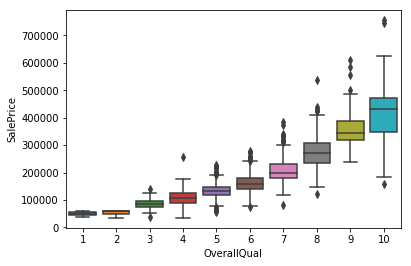

In [48]:
observe_feature(data,'OverallQual','SalePrice')

In [71]:
ft.score_all_features()

LotArea
[['Forest' '-0.0004']
 ['Ada' '0.0144']]
2ndFlrSF
[['Forest' '0.0154']
 ['Ada' '0.0121']]
GrLivArea
[['Forest' '0.0237']
 ['Ada' '0.0101']]
GarageArea
[['Forest' '0.0213']
 ['Ada' '-0.0034']]
LotShape
[['Forest' '-0.0063']
 ['Ada' '0.0093']]
HalfBath
[['Forest' '0.0175']
 ['Ada' '-0.0011']]
Alley
[['Forest' '-0.0113']
 ['Ada' '0.0014']]
Electrical
[['Forest' '0.0225']
 ['Ada' '-0.0075']]
GarageFinish
[['Forest' '0.0161']
 ['Ada' '0.0041']]
PoolQC
[['Forest' '0.0295']
 ['Ada' '0.0017']]
LandContour
[['Forest' '0.0054']
 ['Ada' '0.0153']]
OverallCond
[['Forest' '0.0067']
 ['Ada' '-0.0022']]
OverallQual
[['Forest' '0.0352']
 ['Ada' '0.0635']]
BsmtExposure
[['Forest' '0.0067']
 ['Ada' '-0.0018']]
KitchenQual
[['Forest' '0.0212']
 ['Ada' '0.0056']]
TotRmsAbvGrd
[['Forest' '-0.011']
 ['Ada' '0.0093']]
Fireplaces
[['Forest' '0.031']
 ['Ada' '-0.0002']]
GarageCond
[['Forest' '0.0138']
 ['Ada' '0.0075']]


In [72]:
ft.add_feature('LotArea')
ft.score_feature('LotArea')

ValueError: cannot reshape array of size 8760 into shape (7,1460)

In [73]:
ft.fit()

array([['Forest', '0.7691', '0.0032'],
       ['Ada', '0.7563', '0.0065']], dtype='<U32')

In [76]:
ft.remove_feature('LotArea')

In [79]:
ft.score_feature('LotArea')

array([['Forest', '0.7772', '-0.0107'],
       ['Ada', '0.7442', '-0.0148']], dtype='<U32')